In [1]:
import numpy as np
import matplotlib.pyplot as plt

import librosa
import librosa.display

First, we load and decode the audio as a time series $y$, represented as a one-dimensional NumPy floating point array. The variable $sr$ contains the sampling rate of $y$, that is, the number of samples per second of audio. By default, all audio is mixed to mono and resampled to 22050 Hz at load time.

In [14]:
y, sr = librosa.load('6hoNS9LR1Lxb4EzMX72kXR.ogg')

Next, we run the beat tracker:

The output of the beat tracker is an estimate of the tempo (in beats per minute), and an array of frame numbers corresponding to detected beat events.

Frames here correspond to short windows of the signal (y), each separated by hop_length = 512 samples. librosa uses centered frames, so that the kth frame is centered around sample k * hop_length.



In [30]:
# Run the default beat tracker
tempo, beat_frames = librosa.beat.beat_track(y=y, sr=sr)

The next operation converts the frame numbers beat_frames into timings:


In [31]:
print('Estimated tempo: {:.2f} beats per minute'.format(tempo))
#  Convert the frame indices of beat events into timestamps
beat_times = librosa.frames_to_time(beat_frames, sr=sr)

Estimated tempo: 129.20 beats per minute


Now, beat_times will be an array of timestamps (in seconds) corresponding to detected beat events.

The contents of beat_times should look something like this:

In [32]:
beat_times

array([1.85759637e-01, 6.50158730e-01, 1.16099773e+00, ...,
       2.94373297e+03, 2.94424381e+03, 2.94468499e+03])

In [15]:
librosa.get_duration(y)

2950.974693877551

In [24]:
y.shape

(65068992,)

# Take Samples of Audio File and Basic Wave Form EDA

From 40 minutes till end, use as a subsample to play around

In [40]:
first_40mins = librosa.time_to_samples(60*40, sr=sr)
sub_episode = y[first_40mins:]

In [43]:
sub_episode.shape

(12148992,)

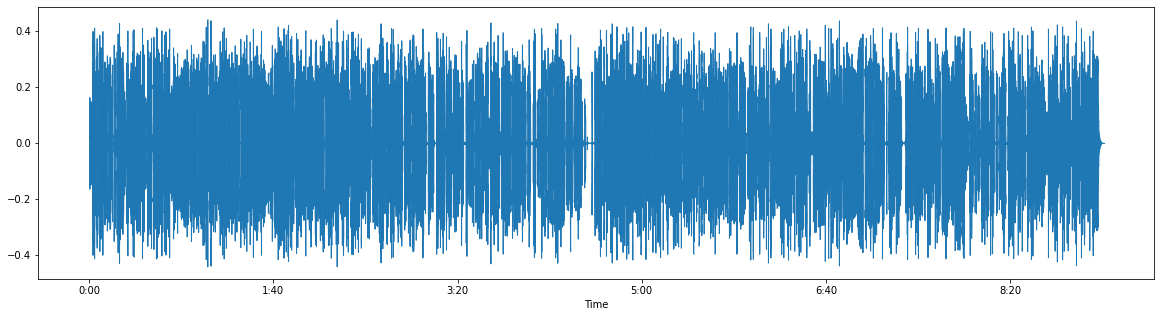

In [45]:
plt.figure(figsize = (20,5))
librosa.display.waveshow(sub_episode, sr=sr)

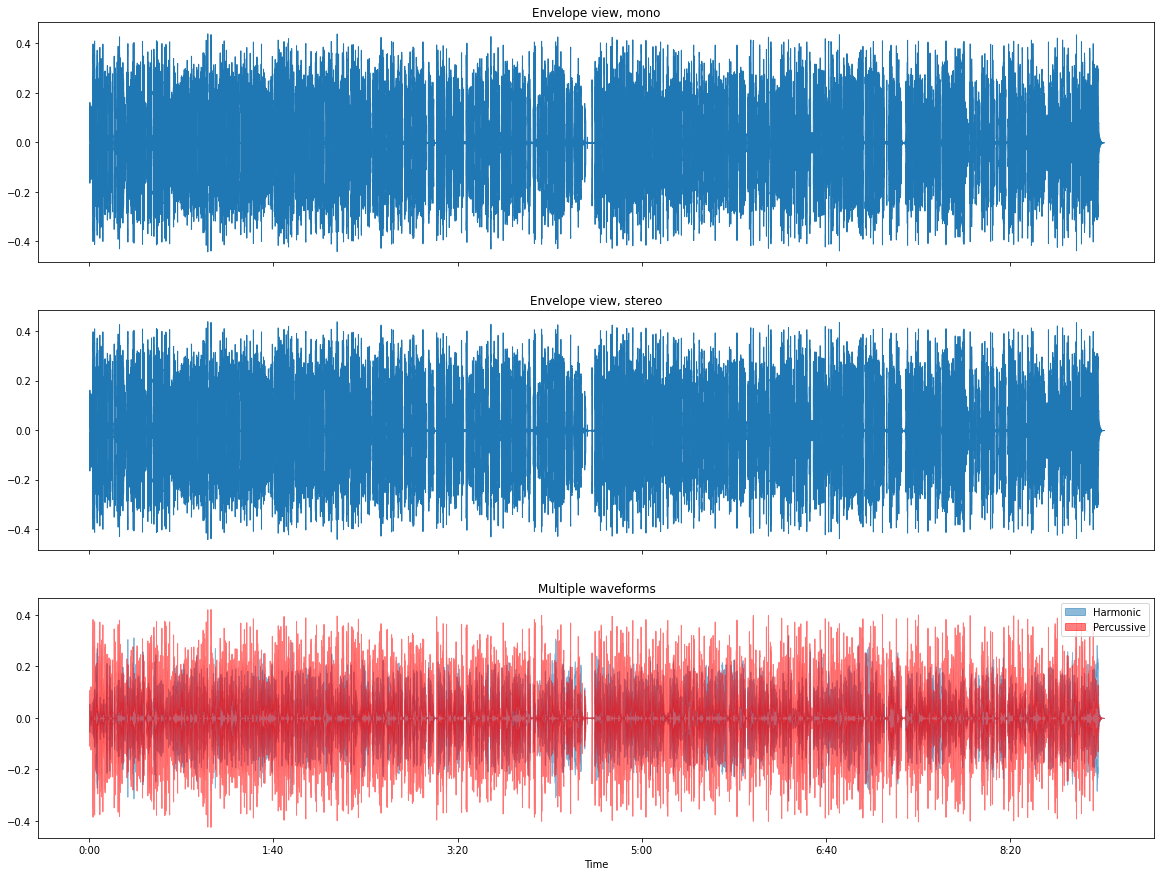

In [57]:
fig, ax = plt.subplots(nrows=3, sharex=True, figsize = (20,15))
librosa.display.waveshow(sub_episode, sr=sr, ax=ax[0])
ax[0].set(title='Envelope view, mono')
ax[0].label_outer()

librosa.display.waveshow(sub_episode, sr=sr, ax=ax[1])
ax[1].set(title='Envelope view, stereo')
ax[1].label_outer()

y_harm, y_perc = librosa.effects.hpss(sub_episode)
librosa.display.waveshow(y_harm, sr=sr, alpha=0.5, ax=ax[2], label='Harmonic')
librosa.display.waveshow(y_perc, sr=sr, color='r', alpha=0.5, ax=ax[2], label='Percussive')
ax[2].set(title='Multiple waveforms')
ax[2].legend()

Zooming in on a plot to show raw sample values

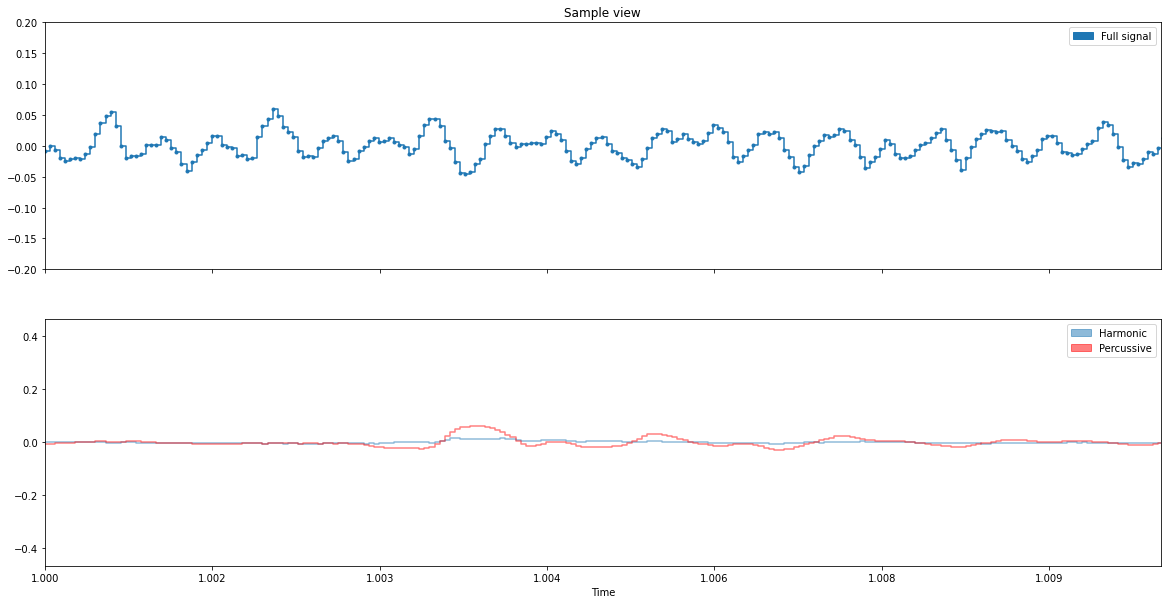

In [60]:
fig, (ax, ax2) = plt.subplots(nrows=2, sharex=True, figsize = (20,10))
ax.set(xlim=[1.0, 1.01], title='Sample view', ylim=[-0.2, 0.2])
librosa.display.waveshow(y, sr=sr, ax=ax, marker='.', label='Full signal')
librosa.display.waveshow(y_harm, sr=sr, alpha=0.5, ax=ax2, label='Harmonic')
librosa.display.waveshow(y_perc, sr=sr, color='r', alpha=0.5, ax=ax2, label='Percussive')
ax.label_outer()
ax.legend()
ax2.legend()

# silence/non-silence overview

Using root mean square curve of sound




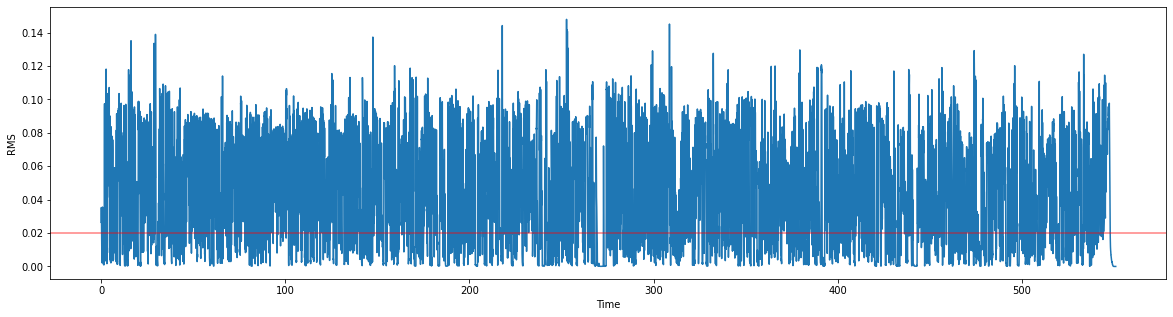

In [46]:
# As a first step, we can plot the root-mean-square (RMS) curve
rms = librosa.feature.rms(y=sub_episode)[0]

times = librosa.frames_to_time(np.arange(len(rms)))

fig, ax = plt.subplots(figsize = (20,5))
ax.plot(times, rms)
ax.axhline(0.02, color='r', alpha=0.5)
ax.set(xlabel='Time', ylabel='RMS');

The red line at 0.02 indicates a reasonable threshold for silence detection. However, the RMS curve occasionally dips below the threshold momentarily, and we would prefer the detector to not count these brief dips as silence.

# Ordinary (linear) spectrogram

STFT: Short-time Fourier transform (STFT).

The STFT represents a signal in the time-frequency domain by computing discrete Fourier transforms (DFT) over short overlapping windows.

In [48]:
D = librosa.stft(sub_episode)  # STFT of y
S_db = librosa.amplitude_to_db(np.abs(D), ref=np.max)

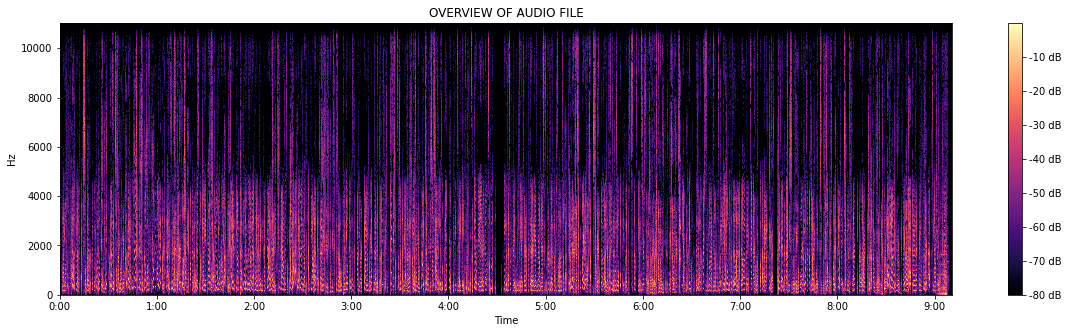

In [49]:
fig, ax = plt.subplots(figsize = (20,5))
img = librosa.display.specshow(S_db, x_axis='time', y_axis='linear', ax=ax)
ax.set(title='OVERVIEW OF AUDIO FILE')
fig.colorbar(img, ax=ax, format="%+2.f dB")

# Mel Spectrogram

A mel is a number that corresponds to a pitch, similar to how a frequency describes a pitch. 

If we consider a note, A4 for example, its frequency is 440 hz. If we move up an octave to A5 its frequency doubles to 880 hz, and doubles again to 1760 at A6. So thats a jump of 440 between the A4 and A5 and 880 between A5 and A6, but the problem is that the human ear doesn’t hear that way. The difference between two notes feels the same whether we jump from C to D or from F to G. But the logarithmic relationship gives different hz values for these different intervals.

The term **mel** comes from the word ‘melodic’ and the mel scale is intended to regularize the intervals between notes. 

In principle the mel is used to display pitch in a more regularized distribution.

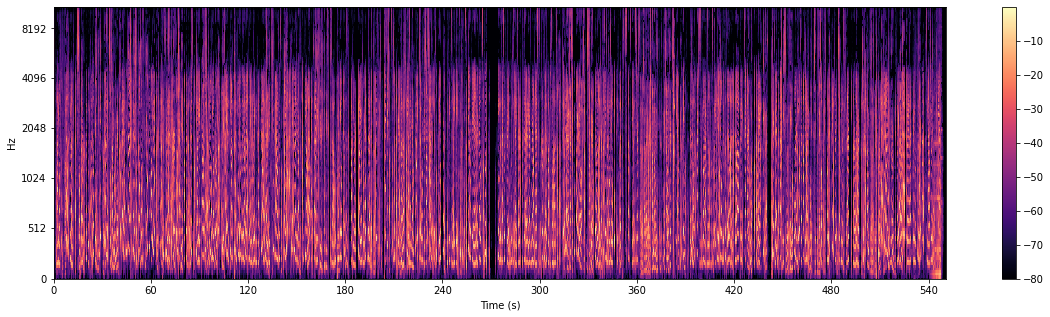

In [50]:
spec = librosa.feature.melspectrogram(y=sub_episode, sr=sr)
db_spec = librosa.power_to_db(spec, ref=np.max,)
plt.figure(figsize = (20,5))
librosa.display.specshow(db_spec,y_axis='mel', x_axis='s', sr=sr)
plt.colorbar();

Librosa can also separate the initial audio series into harmonic and percussive components.

In [51]:
data_h, data_p = librosa.effects.hpss(sub_episode)
spec_h = librosa.feature.melspectrogram(data_h, sr=sr)
spec_p = librosa.feature.melspectrogram(data_p, sr=sr)
db_spec_h = librosa.power_to_db(spec_h,ref=np.max)
db_spec_p = librosa.power_to_db(spec_p,ref=np.max)

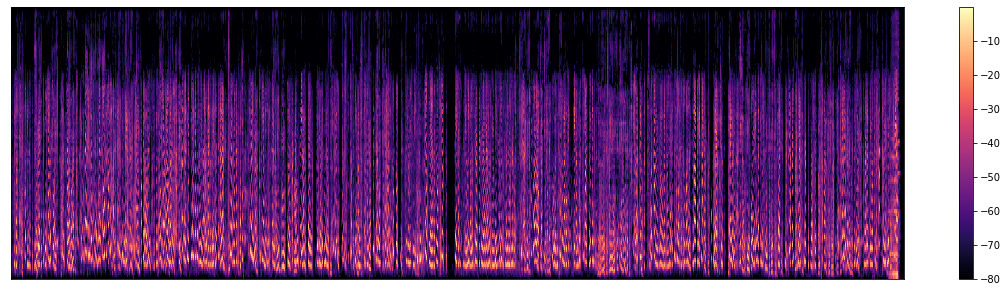

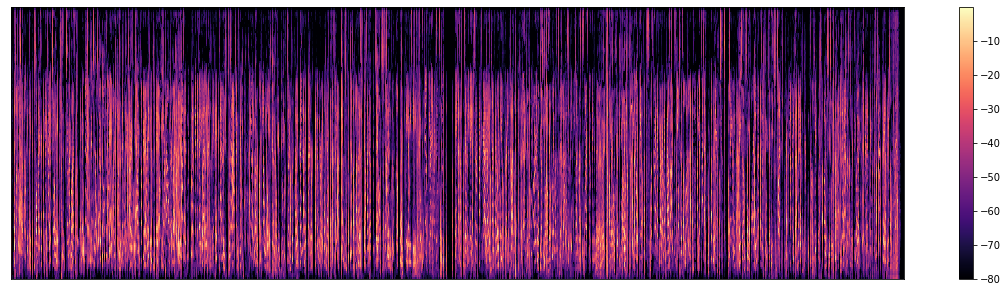

In [53]:
plt.figure(figsize = (20,5))
librosa.display.specshow(db_spec_h)
plt.colorbar();
plt.figure(figsize = (20,5))
librosa.display.specshow(db_spec_p)
plt.colorbar();

# Chroma Plot

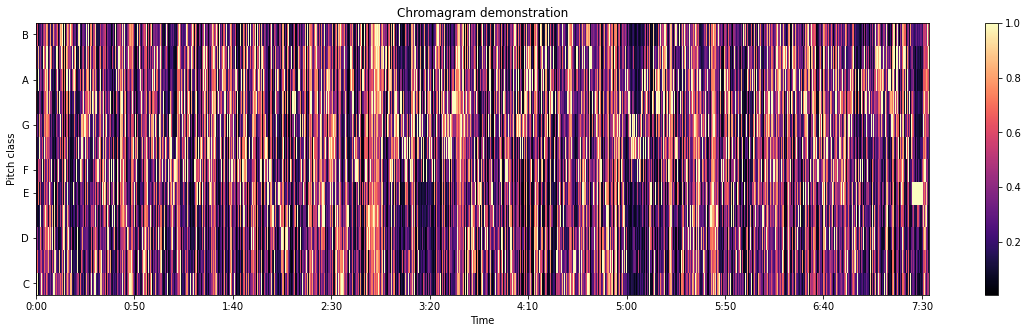

In [27]:
chroma = librosa.feature.chroma_cqt(y=sub_episode, sr=sr)
fig, ax = plt.subplots(figsize = (20,5))
img = librosa.display.specshow(chroma, y_axis='chroma', x_axis='time', ax=ax)
ax.set(title='Chromagram demonstration')
fig.colorbar(img, ax=ax)

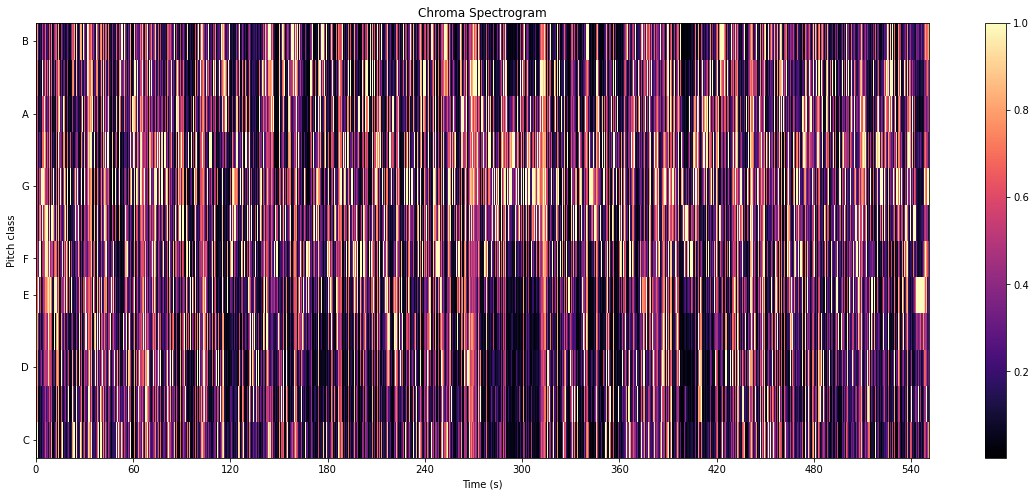

In [44]:
# on harmonic
intro_harm = librosa.effects.harmonic(sub_episode)
intro_chroma = librosa.feature.chroma_cqt(intro_harm, sr=sr)
plt.figure(figsize=(20,8))
plt.title('Chroma Spectrogram')
librosa.display.specshow(intro_chroma, sr=sr, x_axis='s', y_axis='chroma', )
plt.colorbar();

# SuperFlux Onset Plot

SuperFlux - a new onset detection algorithm with vibrato suppression. It is an enhanced version of the universal spectral flux onset detection algorithm, and reduces the number of
false positive detections considerably by tracking spectral trajectories with a maximum filter

More details: http://dafx13.nuim.ie/papers/09.dafx2013_submission_12.pdf

In [6]:
n_fft = 1024
hop_length = int(librosa.time_to_samples(1./200, sr=sr))
lag = 2
n_mels = 138
fmin = 27.5
fmax = 16000.
max_size = 3

/usr/local/lib/python3.7/dist-packages/librosa/filters.py:239: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  "Empty filters detected in mel frequency basis. "


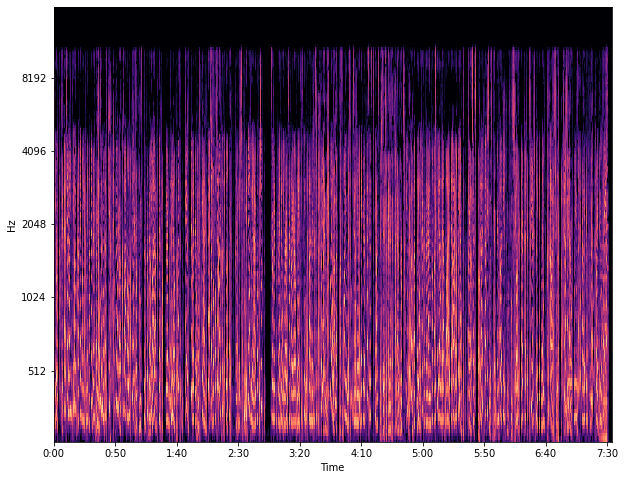

In [7]:
S = librosa.feature.melspectrogram(sub_episode, sr=sr, n_fft=n_fft,
                                   hop_length=hop_length,
                                   fmin=fmin,
                                   fmax=fmax,
                                   n_mels=n_mels)


fig, ax = plt.subplots(figsize = (10,8))
librosa.display.specshow(librosa.power_to_db(S, ref=np.max),
                         y_axis='mel', x_axis='time', sr=sr,
                         hop_length=hop_length, fmin=fmin, fmax=fmax, ax=ax)

In [8]:
odf_default = librosa.onset.onset_strength(y=sub_episode, sr=sr, hop_length=hop_length)
onset_default = librosa.onset.onset_detect(y=sub_episode, sr=sr, hop_length=hop_length,
                                           units='time')

In [9]:
odf_sf = librosa.onset.onset_strength(S=librosa.power_to_db(S, ref=np.max),
                                      sr=sr,
                                      hop_length=hop_length,
                                      lag=lag, max_size=max_size)

onset_sf = librosa.onset.onset_detect(onset_envelope=odf_sf,
                                      sr=sr,
                                      hop_length=hop_length,
                                      units='time')

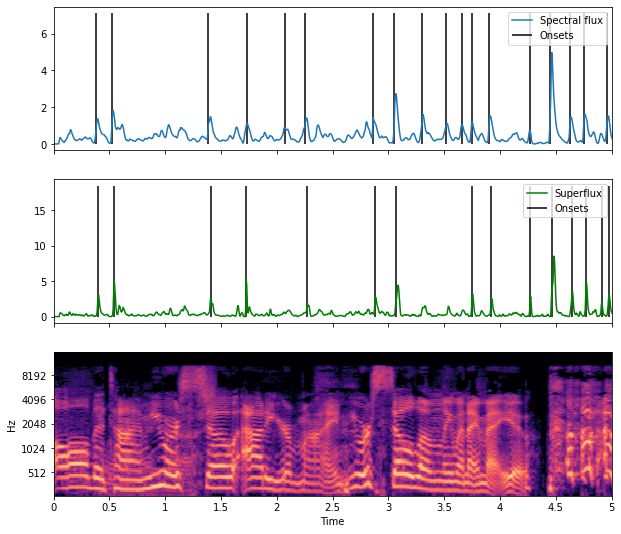

In [11]:
# sphinx_gallery_thumbnail_number = 2
fig, ax = plt.subplots(figsize = (10,9), nrows=3, sharex=True)

frame_time = librosa.frames_to_time(np.arange(len(odf_default)),
                                    sr=sr,
                                    hop_length=hop_length)

librosa.display.specshow(librosa.power_to_db(S, ref=np.max),
                         y_axis='mel', x_axis='time', sr=sr,
                         hop_length=hop_length, fmin=fmin, fmax=fmax, ax=ax[2])
ax[2].set(xlim=[0, 5.0])


ax[0].plot(frame_time, odf_default, label='Spectral flux')
ax[0].vlines(onset_default, 0, odf_default.max(), label='Onsets')
ax[0].legend()
ax[0].label_outer()

ax[1].plot(frame_time, odf_sf, color='g', label='Superflux')
ax[1].vlines(onset_sf, 0, odf_sf.max(), label='Onsets')
ax[1].legend()
ax[0].label_outer()